<a href="https://colab.research.google.com/github/mehdi2019gaied/Spot-mask-challenge-Deep-learning-/blob/main/Deep_learning__spot__mask_mehdi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Spot the Mask Challenge**


Here what we'll do in this kernel:


 
  1-Loading & Looking at the data 

  2-Data Preprocessing

  3-Build and Train a Baseline Model
  
  4-test
   







    




# Import & Functions definition

In [ ]:
#IMPORTER
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
import os
from PIL import Image # used for loading images
import numpy as np
import os # used for navigating to image path
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%tensorflow_version 2.x) #to avoid loading another version at run time (since you can't change it after it's imported)
import tensorflow as tf
import gc

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x) #to avoid loading another version at run time (since you can't change it after it's imported)`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


# Loading the dataset repository 

##Dataset Description
The data have been split into a test and training set. The training set contains ~1300 images and the test set contains 509 images. There are two types of images in this dataset, people or images with face masks and people or images without.

The task is to provide the probability that an image contains at least one mask. For each unique image ID you should estimate the likelihood that the image contains at least one mask, with an estimated probability value between 0 and 1.

## Loading zip repository from Drive 
the zip file contains all images and train csv file  list of images in the train set, 1 indicates an image with a person with a mask, 0 indicates a person without a mask. 

In [ ]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
auth = GoogleAuth()
auth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(auth)

# Download a file based on its file ID.
file_id = '1hxmsENX57RSZucf-zjffFmuWQ_Yw6B_9' #-- Updated File ID for my Zip
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString(encoding='cp862')))


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:

dataset = io.BytesIO(downloaded.GetContentFile('images2.Zip') )
!unzip /content/images2.Zip

Archive:  /content/images2.Zip
replace images/wiovvusmzmxindaealykgesxwwleql.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!rm images2.Zip

In [ ]:
#Define Path to images 
PATH= os.getcwd()+'/images'
PATH

'/content/images'

In [ ]:
#Now create a python dictionary, naming_dict which contains the mapping from id to labels 0 or 1.
naming_dict = {} # id: 0 or 1 (mask or not)
f = open("/content/train_labels.csv", "r")
next(f, None)
fileContents = f.read()
fileContents = fileContents.split('\n')
for i in range(len(fileContents)-1):
  img_file= fileContents[i].split(',')
  img_ID  =img_file[0].split('.')
  naming_dict [img_ID[0] ] = int(img_file[1])

naming_dict

{'tfymlmdkpzkqdjhdxyhnoeuqszxphw': 0,
 'rxgismgsvmaayzjarbfjaljhqmpbrt': 1,
 'uuzshfrhkgrkolhwdvliqauzulurnz': 0,
 'mjspxsagzusaznvnyxgamtrlqkqklp': 0,
 'rlbmuajgezfiddjzlyeoupxpqubkpt': 1,
 'ngvvhadzegowlxligtftkbucwyphvw': 0,
 'qlwbzgvdyqwncrvqzaezrrqlwuugdp': 1,
 'lbbmpcbdwgdbskcdmsanklchyknuig': 0,
 'xgpvctqkxpuljjixphprbdrkcuzfoi': 0,
 'tszmhququgjczggoxanwvdlzbdbxhb': 0,
 'qvqhxwbgpskanqpsfbigdmbpkenvgk': 0,
 'eqirckpknxclvrlxvfxaswsodbxlmm': 1,
 'yoewqnzdgdhogcwdageakflfeogisq': 0,
 'hpnmywojyjwgptgkflzydzenfxbtlr': 1,
 'dnzimlvqpkwyhmsdwqwpuewzbdqzmg': 1,
 'hcysrvramduefsgkkgvqbmxzlodgal': 1,
 'spdcmncwcnpqagxrlivyldeknnfcvr': 1,
 'zaemovvkdftxvorancdugwjzuodbmm': 1,
 'uvpqnqfujwsxhbgvfbvcidhcqnyuum': 0,
 'kzgroxmxsdfrkxusymupjaxumbwoow': 1,
 'cjsjioqkweumqcnobaydijuvfvtrel': 1,
 'iehmewhtlomanneoicvbyjonzzcbhh': 0,
 'uiclughuenqkjonhhjgjclflpqkhsk': 0,
 'hfbevhhmejjmdndclkpyeyaideyjgp': 1,
 'pmociluihyptefnqdlihzzodiczkso': 0,
 'qkishcozhztulvrhvodbabprxomeuq': 0,
 'gvpxmmxppq

##Convert PNG image to JPG (RGB)
> we need to convert the images with 4 channels to RGB channels such as those in png format so as to standardize them, because our model only accepts a single fixed channels number  

In [ ]:
def convert_image(PATH):  
  for img in os.listdir(PATH):
      split= img.split('.')
      imgName=split[0]
      ext=split[1]
      path = os.path.join(PATH, img)
      if ext=='png' or imread(path).shape[2]==4:
        im = Image.open(path)
        im = im.convert('RGB')  
        im.save(PATH+'/'+imgName+'.jpg', quality=95)
        os.remove(path)
  return 'Conversion completed'
convert_image(PATH)


'Conversion completed'

# Data Preprocessing

##Resizing Images
>When we are formatting images to be inputted to a Keras model, we must specify the input dimensions. Many academic datasets like CIFAR-10 or MNIST are all conveniently the same size, (32x32x3 and 28x28x1 respectively). However, in the ImageNet dataset and this spot Mask detector challenge dataset, we have many different sizes of images. First, we will write some code to loop through the images and gather some descriptive statistics on the maximum, mean, and minimum height and width of the dog images.

In [ ]:
def get_size_statistics(PATH):
  heights = []
  widths = []
  for img in os.listdir(PATH): 
    path = os.path.join(PATH, img)
    data = np.array(Image.open(path)) #PIL Image library
    heights.append(data.shape[0])
    widths.append(data.shape[1])
  avg_height = sum(heights) / len(heights)
  avg_width = sum(widths) / len(widths)
  print("Average Height: ",avg_height)
  print("Max Height: ",max(heights))
  print("Min Height: ", min(heights))
  print('\n')
  print("Average Width: ",avg_width)
  print("Max Width: " ,max(widths))
  print("Min Width: " ,min(widths))

get_size_statistics(PATH)

Average Height:  446.8226872246696
Max Height:  3642
Min Height:  110


Average Width:  624.8177312775331
Max Width:  4698
Min Width:  115


In [ ]:
#Resize images
def resize300(img):
    return resize(img, (128,128), preserve_range=True, mode='reflect', anti_aliasing=True)


##Loading train and test Images
> For this subsection we'll:

*   Load the dataset (train and test)
*   Encode classes (from integers into one-hot vectors)
*   Normalize images (floats & values between [0-1]) 
*   Split train set into train and validation set




In [ ]:
#At this point, we’re ready to load and pre-process our training data:
def build_train_test_data(naming_dict,PATH):
  train_data = []
  test_data= []
  label_train=[]
  # loop over the image paths
  for img in os.listdir(PATH):
      imgName = img.split('.')[0]
      path = os.path.join(PATH, img)
      if imgName in naming_dict:
        # load the input image (128x128) and preprocess it
        train_data+= [np.expand_dims(resize300(imread(path)),0)]
        # extract the class label from the filename   
        label_train+= [np.expand_dims(np.array(naming_dict[imgName]),0)]
      else:
        test_data+= [np.expand_dims(resize300(imread(path)),0)]
  X_train=np.vstack(train_data)   
  X_test=np.vstack(test_data)
  Y_train=np.vstack(label_train)

  return X_train ,X_test,Y_train

X_train,X_test,Y_train=build_train_test_data(naming_dict,PATH)

In [ ]:
X_train.shape,X_test.shape,Y_train.shape

((1307, 128, 128, 3), (509, 128, 128, 3), (1307, 1))

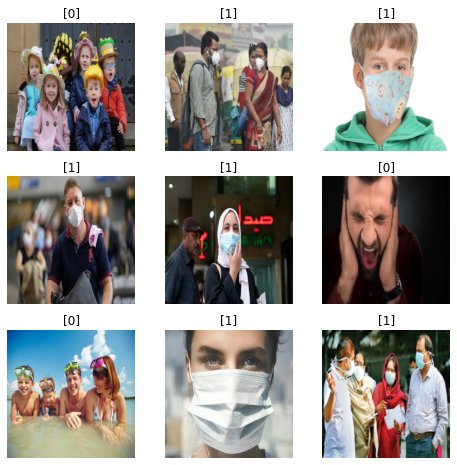

In [ ]:
# Looking at some data
def display_images(images_, labels_, rows_, cols_, additional_input_=''):#sample here is an image from a dataset 
  fig = plt.figure(figsize=(8,8))
  for img in range(rows_*cols_):
    ax = fig.add_subplot(rows_,cols_,1+img)
    ax.imshow(images_[img]/255)
    ax.set_axis_off()
    if additional_input_!='':
      ax.set_title(str(labels_[img])+ ' vs: ' +str(additional_input_[img]))
    else:
      ax.set_title(str(labels_[img]))
display_images(X_train, Y_train, 3, 3)

In [ ]:
def normalize(train_images_, test_images_):
	# convert from integers to floats
	train_norm = train_images_.astype('float32')
	test_norm = test_images_.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm


In [ ]:
# Encode Label , Normalize and Split data
Y_train_enc = tf.keras.utils.to_categorical(Y_train)
X_train, X_test = normalize(X_train,X_test)
category_size=Y_train_enc.shape[1]
input_shape=X_train[0].shape
print('DataLoaded, And Normalized')
print('input shape:',input_shape)
print('label shape:',category_size)

DataLoaded, And Normalized
input shape: (128, 128, 3)
label shape: 2


In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
validation_size = 0.2
train_images, valid_images, label_train, label_valid = train_test_split(X_train,Y_train_enc,test_size=validation_size,stratify=Y_train_enc,
                                                                        random_state=42,shuffle=True)

In [ ]:
print ('The size of our training "X" (input features) is', train_images.shape)
print ('The size of our validation "X" (input features) is', valid_images.shape)
print ('The size of our training  "y" (output feature) is', label_train.shape)
print ('The size of our validation "y" (output features) is', label_valid.shape)

The size of our training "X" (input features) is (1045, 128, 128, 3)
The size of our validation "X" (input features) is (262, 128, 128, 3)
The size of our training  "y" (output feature) is (1045, 2)
The size of our validation "y" (output features) is (262, 2)


#Build and Train our made model

In [ ]:
#### Create a basic model made of a convolutional bloc (e.g., at least one convolutional layer followed by a maxpooling layer)
def my_model(filter_size_, kernel_size_, max_pooling_size_, activation_type_=None, input_shape_=None): 
  model_ = tf.keras.Sequential()
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_, kernel_size=kernel_size_, activation=activation_type_, input_shape=input_shape_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.BatchNormalization())
  model_.add(tf.keras.layers.MaxPooling2D(max_pooling_size_))
  model_.add(tf.keras.layers.Dropout(0.2))

  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*2, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*2, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.BatchNormalization())
  model_.add(tf.keras.layers.MaxPooling2D(max_pooling_size_))
  model_.add(tf.keras.layers.Dropout(0.3))

  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*4, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*4, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_*4, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.BatchNormalization())
  model_.add(tf.keras.layers.MaxPooling2D(max_pooling_size_))
  model_.add(tf.keras.layers.Dropout(0.4))
  return model_

In [ ]:
init_model = my_model(32, (3, 3), (2, 2), activation_type_='relu', input_shape_=input_shape)


##Without Data Augmentation

In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
high_lay = tf.keras.Sequential()
high_lay.add(tf.keras.layers.Flatten())
high_lay.add(tf.keras.layers.Dense(1024, activation='relu'))
high_lay.add(tf.keras.layers.Dense(512, activation='relu'))
high_lay.add(tf.keras.layers.Dense(128, activation='relu'))
high_lay.add(tf.keras.layers.Dense(32, activation='relu'))
high_lay.add(tf.keras.layers.Dense(category_size,activation='softmax'))

model= tf.keras.Sequential([
   init_model, 
    high_lay
])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 16, 16, 128)       435488    
_________________________________________________________________
sequential_4 (Sequential)    (None, 2)                 34150114  
Total params: 34,585,602
Trainable params: 34,585,154
Non-trainable params: 448
_________________________________________________________________


In [ ]:
#### Compile your model (use Adam optimizer and choose a  binary_crossentropy and metric)
epochs = 250
opt =tf.keras.optimizers.Adam(lr=0.0004, decay=0.0004 / epochs)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
augment_data=False
if augment_data:
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  it_train = datagen.flow(train_images, train_labels_encoded, batch_size=64)

In [ ]:
#### Fit the model 

if augment_data:
  print("Training with Augmented Data")
  steps = int(train_images.shape[0] / 64)
  history = model.fit(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(test_images, test_labels_encoded), verbose=1)
else: 
  print("Training withOUT Augmented Data")
  history = model.fit(train_images, label_train, epochs=epochs, batch_size=64, 
                    validation_data=(valid_images, label_valid))

Training withOUT Augmented Data
Epoch 1/250
17/17 [==============================] - 11s 150ms/step - loss: 2.8343 - accuracy: 0.5229 - val_loss: 0.8751 - val_accuracy: 0.5076
Epoch 2/250
17/17 [==============================] - 2s 113ms/step - loss: 0.6711 - accuracy: 0.6582 - val_loss: 1.4121 - val_accuracy: 0.4924
Epoch 3/250
17/17 [==============================] - 2s 105ms/step - loss: 0.5344 - accuracy: 0.7457 - val_loss: 2.9315 - val_accuracy: 0.4924
Epoch 4/250
17/17 [==============================] - 2s 105ms/step - loss: 0.3824 - accuracy: 0.8153 - val_loss: 3.2010 - val_accuracy: 0.4924
Epoch 5/250
17/17 [==============================] - 2s 105ms/step - loss: 0.4280 - accuracy: 0.8339 - val_loss: 2.0150 - val_accuracy: 0.4924
Epoch 6/250
17/17 [==============================] - 2s 105ms/step - loss: 0.2510 - accuracy: 0.8969 - val_loss: 3.3222 - val_accuracy: 0.4924
Epoch 7/250
17/17 [==============================] - 2s 107ms/step - loss: 0.1655 - accuracy: 0.9361 - val_lo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


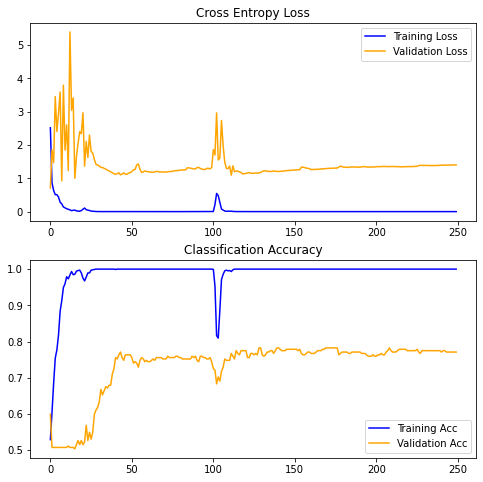

In [ ]:
##### Display the loss and metric curves  
def accuracy_lost_curves(history):
  # plot loss
  fig = plt.figure(figsize=(8,8))
  ax1 = fig.add_subplot(2,1,1)
  ax1.plot(history.history['loss'], color='blue', label='train')
  ax1.plot(history.history['val_loss'], color='orange', label='test')
  ax1.set_title('Cross Entropy Loss')
  ax1.legend(['Training Loss', 'Validation Loss'])
	# plot accuracy
  ax2 = fig.add_subplot(2,1,2)
  ax2.plot(history.history['accuracy'], color='blue', label='train')
  ax2.plot(history.history['val_accuracy'], color='orange', label='test')
  ax2.set_title('Classification Accuracy')
  ax2.legend(['Training Acc', 'Validation Acc'])
  
# Learning curves
accuracy_lost_curves(history)

***Interprétation***:
D'après la figure ci dessus on distingue qu'il y a un décalge remarquable entre les deux courbes d'accuracy et de loss (train et valdiation), alros le modèle n'arrive pas à bien généraliser, il paraît bien qu'il ya un overfitting, Il y a des stratégies qui, selon moi, seraient les plus efficaces pour améliorer ce score de précision de test tels que le Data Augmentation

##With Data Augmentation

In [ ]:
base_model = conv_block(32, (3, 3), (2, 2), activation_type_='relu', input_shape_=input_shape)
top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.Flatten())
top_layers.add(tf.keras.layers.Dense(1024, activation='relu'))
top_layers.add(tf.keras.layers.Dense(512, activation='relu'))
top_layers.add(tf.keras.layers.Dense(128, activation='relu'))
top_layers.add(tf.keras.layers.Dense(32, activation='relu'))
top_layers.add(tf.keras.layers.Dense(category_size,activation='softmax'))

model= tf.keras.Sequential([
    base_model, 
    top_layers
])

In [ ]:
epochs = 250
opt =tf.keras.optimizers.Adam(lr=0.0004, decay=0.0004 / epochs)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# construct the training image generator for data augmentation
augment_data=True
if augment_data:
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2, 
                                                            height_shift_range=0.2,
                                                            zoom_range=0.15,
                                                            rotation_range=20,
                                                            shear_range=0.15,
                                                            fill_mode="nearest",
                                                            horizontal_flip=True)
  it_train = datagen.flow(train_images, label_train, batch_size=64)

In [ ]:
#### Fit the model (you can use the test set as your validation data)
if augment_data:
  print("Training with Augmented Data")
  steps_tr = int(train_images.shape[0] / 64)
  steps_ts = int(valid_images.shape[0] / 64)

  history = model.fit(it_train, steps_per_epoch=steps_tr, 
                      epochs=epochs,
                      validation_data=(valid_images, label_valid), 
                      validation_steps=steps_ts,
                      verbose=1)
else: 
  print("Training withOUT Augmented Data")
  history = model.fit(train_images, train_labels_encoded, epochs=epochs, batch_size=64, 
                    validation_data=(test_images, test_labels_encoded))

Training with Augmented Data
Epoch 1/250
16/16 [==============================] - 4s 260ms/step - loss: 2.6598 - accuracy: 0.4822 - val_loss: 0.7063 - val_accuracy: 0.5420
Epoch 2/250
16/16 [==============================] - 4s 235ms/step - loss: 1.2541 - accuracy: 0.4980 - val_loss: 0.6971 - val_accuracy: 0.4962
Epoch 3/250
16/16 [==============================] - 4s 226ms/step - loss: 0.8476 - accuracy: 0.5872 - val_loss: 0.8669 - val_accuracy: 0.5038
Epoch 4/250
16/16 [==============================] - 4s 222ms/step - loss: 0.9013 - accuracy: 0.5433 - val_loss: 0.7101 - val_accuracy: 0.5534
Epoch 5/250
16/16 [==============================] - 4s 226ms/step - loss: 0.7405 - accuracy: 0.5984 - val_loss: 0.8423 - val_accuracy: 0.5076
Epoch 6/250
16/16 [==============================] - 4s 227ms/step - loss: 0.7084 - accuracy: 0.6096 - val_loss: 0.6749 - val_accuracy: 0.5687
Epoch 7/250
16/16 [==============================] - 4s 221ms/step - loss: 0.6799 - accuracy: 0.6024 - val_loss: 

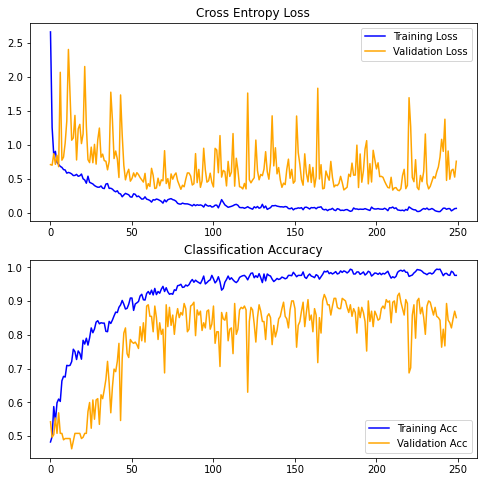

In [ ]:
##### Display the loss and metric curves  
def accuracy_lost_curves(history):
  # plot loss
  fig = plt.figure(figsize=(8,8))
  ax1 = fig.add_subplot(2,1,1)
  ax1.plot(history.history['loss'], color='blue', label='train')
  ax1.plot(history.history['val_loss'], color='orange', label='test')
  ax1.set_title('Cross Entropy Loss')
  ax1.legend(['Training Loss', 'Validation Loss'])
	# plot accuracy
  ax2 = fig.add_subplot(2,1,2)
  ax2.plot(history.history['accuracy'], color='blue', label='train')
  ax2.plot(history.history['val_accuracy'], color='orange', label='test')
  ax2.set_title('Classification Accuracy')
  ax2.legend(['Training Acc', 'Validation Acc'])
  
# Learning curves
accuracy_lost_curves(history)

***Interprétation***:
Ici on distingue qu'il y a un décalge entre les deux courbes s'est diminué en utilisant le data augmentaion technique , alros le modèle arrive à mieux généraliser.On arrive à 86% de validation accuracy

#Transfer Learning with Data Augmentation

##Transfer Learning: MobileNetV2

> ***In this section:***
The Pre-processing steps include resizing to 224×224 pixels, conversion to array format, and scaling the pixel intensities in the input image to the range [-1, 1] (via the preprocess_input convenience function of MobileNetV2)

In [ ]:

def resize300(img):
    return resize(img, (224,224), preserve_range=True, mode='reflect', anti_aliasing=True)

def build_train_test_data(naming_dict,PATH):
  train_data = []
  test_data= []
  label_train=[]
  for img in os.listdir(PATH):
      imgName = img.split('.')[0]
      path = os.path.join(PATH, img)
      if imgName in naming_dict:
        train_data+= [np.expand_dims(tf.keras.applications.mobilenet_v2.preprocess_input(resize300(imread(path))),0)]  
        label_train+= [np.expand_dims(np.array(naming_dict[imgName]),0)]
      else:
        test_data+= [np.expand_dims(tf.keras.applications.mobilenet_v2.preprocess_input(resize300(imread(path))),0)]
  X_train=np.vstack(train_data)   
  X_test=np.vstack(test_data)
  Y_train=np.vstack(label_train)

  return X_train ,X_test,Y_train

X_train,X_test,Y_train=build_train_test_data(naming_dict,PATH)

In [ ]:
X_train.shape,X_test.shape,Y_train.shape

((1307, 224, 224, 3), (509, 224, 224, 3), (1307, 1))

In [ ]:
Y_train_enc = tf.keras.utils.to_categorical(Y_train)
category_size=Y_train_enc.shape[1]
input_shape=X_train[0].shape
print(' DataLoaded, And Normalized')
print('input shape:',input_shape)
print('label shape:',category_size)

 DataLoaded, And Normalized
input shape: (224, 224, 3)
label shape: 2


In [ ]:
# Split-out validation dataset
validation_size = 0.2
train_images, valid_images, label_train, label_valid = train_test_split(X_train,Y_train_enc,test_size=validation_size,stratify=Y_train_enc,
                                                                        random_state=42,shuffle=True)

In [ ]:
print ('The size of our training "X" (input features) is', train_images.shape)
print ('The size of our validation "X" (input features) is', valid_images.shape)
print ('The size of our training  "y" (output feature) is', label_train.shape)
print ('The size of our validation "y" (output features) is', label_valid.shape)

The size of our training "X" (input features) is (1045, 224, 224, 3)
The size of our validation "X" (input features) is (262, 224, 224, 3)
The size of our training  "y" (output feature) is (1045, 2)
The size of our validation "y" (output features) is (262, 2)


***we need now to prepare MobileNetV2 for fine-tuning:***

---



In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
get_model = tf.keras.applications.MobileNetV2(weights = 'imagenet', include_top = False, input_shape=input_shape)
init_model.trainable = False # loop over all layers in the init_model and freeze them so they will
# *not* be updated during the first training process

In [ ]:
high_lay = tf.keras.Sequential()
high_lay.add(tf.keras.layers.GlobalAveragePooling2D())
high_lay.add(tf.keras.layers.Flatten())
high_lay.add(tf.keras.layers.Dense(128, activation='relu'))
high_lay.add(tf.keras.layers.BatchNormalization())
high_lay.add(tf.keras.layers.Dropout(0.9))
high_lay.add(tf.keras.layers.Dense(category_size,activation='softmax'))

model= tf.keras.Sequential([
    get_model, 
    high_lay
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
sequential_1 (Sequential)    (None, 2)                 164738    
Total params: 2,422,722
Trainable params: 2,388,354
Non-trainable params: 34,368
_________________________________________________________________


In [ ]:
epochs = 150
opt =tf.keras.optimizers.Adam(lr=0.0004, decay=0.0004 / epochs)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
augment_data=True
if augment_data:
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2, 
                                                            height_shift_range=0.2,
                                                            zoom_range=0.15,
                                                            rotation_range=20,
                                                            shear_range=0.15,
                                                            fill_mode="nearest",
                                                            horizontal_flip=True)
  it_train = datagen.flow(train_images, label_train, batch_size=64)

In [ ]:
#### Fit the model (you can use the test set as your validation data)
if augment_data:
  print("Training with Augmented Data")
  steps_tr = int(train_images.shape[0] / 64)
  steps_ts = int(valid_images.shape[0] / 64)

  history = model.fit(it_train, steps_per_epoch=steps_tr, 
                      epochs=epochs,
                      validation_data=(valid_images, label_valid), 
                      validation_steps=steps_ts,
                      verbose=1)
else: 
  print("Training withOUT Augmented Data")
  history = model.fit(train_images, train_labels_encoded, epochs=epochs, batch_size=64, 
                    validation_data=(test_images, test_labels_encoded))

Training with Augmented Data
Epoch 1/150
16/16 [==============================] - 25s 842ms/step - loss: 1.7475 - accuracy: 0.5707 - val_loss: 0.4179 - val_accuracy: 0.8588
Epoch 2/150
16/16 [==============================] - 12s 765ms/step - loss: 0.7028 - accuracy: 0.8066 - val_loss: 1.8206 - val_accuracy: 0.7252
Epoch 3/150
16/16 [==============================] - 12s 758ms/step - loss: 0.3373 - accuracy: 0.8937 - val_loss: 2.4420 - val_accuracy: 0.7443
Epoch 4/150
16/16 [==============================] - 12s 752ms/step - loss: 0.2741 - accuracy: 0.9055 - val_loss: 1.7645 - val_accuracy: 0.7786
Epoch 5/150
16/16 [==============================] - 12s 750ms/step - loss: 0.2270 - accuracy: 0.9276 - val_loss: 0.9963 - val_accuracy: 0.8779
Epoch 6/150
16/16 [==============================] - 12s 749ms/step - loss: 0.1769 - accuracy: 0.9274 - val_loss: 1.3720 - val_accuracy: 0.8359
Epoch 7/150
16/16 [==============================] - 12s 748ms/step - loss: 0.1163 - accuracy: 0.9550 - val

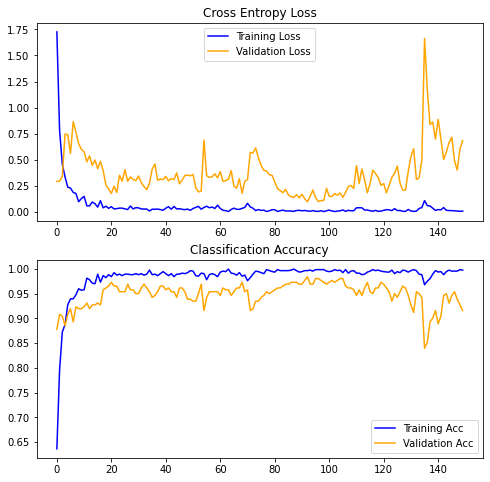

In [ ]:
##### Display the loss and metric curves  
def accuracy_lost_curves(history):
  # plot loss
  fig = plt.figure(figsize=(8,8))
  ax1 = fig.add_subplot(2,1,1)
  ax1.plot(history.history['loss'], color='blue', label='train')
  ax1.plot(history.history['val_loss'], color='orange', label='test')
  ax1.set_title('Cross Entropy Loss')
  ax1.legend(['Training Loss', 'Validation Loss'])
	# plot accuracy
  ax2 = fig.add_subplot(2,1,2)
  ax2.plot(history.history['accuracy'], color='blue', label='train')
  ax2.plot(history.history['val_accuracy'], color='orange', label='test')
  ax2.set_title('Classification Accuracy')
  ax2.legend(['Training Acc', 'Validation Acc'])
  
# Learning curves
accuracy_lost_curves(history)

***Interprétation***:
D'après la figure ci dessus on distingue qu'il n'y aucun décalge entre les deux courbes d'accuracy et de loss (train et valdiation), cependant on remarque qu'au debut des itérations(jusqu'à 80 itérations) la courbe de validation que soit pour accuracy et loss est au dessus de celle de train, ceci est dû principalement des poids gelés du modèle pré-entrainé(MobileNetV2), ils marchent très bien avec nos images,  alros le modèle arrive à très  bien généraliser, on arrive à 95%

TEST

In [ ]:
 test_data=[]
 for img in os.listdir(PATH):
      imgName = img.split('.')[0]
      path = os.path.join(PATH, img)
      if imgName not in naming_dict:
        test_data+= [img]

In [ ]:
len(test_data)

509

In [ ]:
prediction=model.predict(X_test)
prediction=prediction.T[0]
test_results= pd.DataFrame({"image":test_data, "target":prediction.reshape(1,-1)[0]}) 
test_results.head()

,image,target
0,bvrbztwngoiduyhlrnxnybuqamwdjq.jpg,0.997565
1,fuldxhllmyyhygdvrczspchtlwifqm.jpg,0.999990
2,pektafvzybcgssvemzxjypfzsriqxx.jpg,0.000010
3,lyousdaviagybwamxfwdjpjfevopkf.jpeg,0.999999
4,qcwfppwrwajqvcjtzgadczsmjjglpa.jpg,1.000000


In [ ]:
test_results.to_csv('/content/subm.csv',index=False)